<a href="https://colab.research.google.com/github/patel-zeel/ES654-2020-code/blob/master/Active%20Learning%20with%20Bayesian%20Linear%20Regression/Active_Learning_with_Bayesian_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning with Bayesian Linear Regression
> A programming introduction to Active Learning with Bayesian Linear Regression.

- toc: true 
- badges: true
- comments: true
- image: images/blr-map.png
- author: Zeel Patel & Nipun Batra
- categories: [ML]

We are going to showcase two cases of Active Learning here i) Query by Committee(QBC) and ii) Uncertainty sampling.

To review Bayesian Linear Regression and Active Learning individually, go to the links below.  

[Bayesian Linear Regression](https://nipunbatra.github.io/blog/ml/2020/02/20/bayesian-linear-regression.html)  
[Active Learning](https://nipunbatra.github.io/blog/ml/2018/06/16/active-committee.html)

#### Creating scikit-learn like Fit Predict class for Bayesian Linear Regression

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
np.random.seed(42)

In [0]:
class BLR():
  def __init__(self,S0, M0):
    self.S0 = S0
    self.M0 = M0
  def fit(self,x,y, return_self = False):
    self.x = x
    self.y = y

    x_plus_1 = np.hstack((x, np.ones(x.shape[0]).reshape(-1,1)))
    #print(x_plus_1.shape)
    theta_mle = np.linalg.pinv(x_plus_1.T@x_plus_1)@(x_plus_1.T@y)
    sigma_2_mle = np.linalg.norm(y - x_plus_1@theta_mle)**2
    sigma_mle = np.sqrt(sigma_2_mle)

    self.SN = np.linalg.pinv(np.linalg.pinv(self.S0) + (sigma_mle**-2)*x_plus_1.T@x_plus_1)
    self.MN = self.SN@(np.linalg.pinv(self.S0)@self.M0 + (sigma_mle**-2)*(x_plus_1.T@y).squeeze())

    self.pred_var = x_plus_1@self.SN@x_plus_1.T
    self.y_hat_map = x_plus_1@self.MN
    if return_self:
      return (self.y_hat_map, self.pred_var)
    
  def predict(self, x):
    x_plus_1 = np.hstack((x, np.ones(x.shape[0]).reshape(-1,1)))
    self.pred_var = x_plus_1@self.SN@x_plus_1.T
    self.y_hat_map = x_plus_1@self.MN
    return (self.y_hat_map, self.pred_var)
  def plot(self, s=1):
    individual_var = self.pred_var.diagonal()
    plt.figure()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(self.x[:,0], self.y_hat_map, color='black', label='predicted')
    plt.fill_between(self.x[:,0], self.y_hat_map-individual_var, self.y_hat_map+individual_var, alpha=0.4, color='black', label='predicted variance')
    plt.scatter(self.x[:,0], self.y, label='actual data',s=s)
    plt.legend()

#### Creating & visualizing dataset

In [0]:
# Uncomment the following lines to learn an order 1 line function
"""
X = np.linspace(-2, 2, 1000)
Y = 4 *X + 5 + np.random.randn(1000, )
"""
# Uncomment the following lines to learn a high order polinomial function
"""
X = np.linspace(-2, 2, 1000)
Y = 4*X**3 + 2*X**2 + 5 * X + 4 + 2 * np.random.randn(1000, )
"""
# Uncomment the following lines to learn diabetes dataset from sklearn

X, Y = datasets.load_diabetes(return_X_y=True)
X = X[:, 2] # Choosing only feature 2 which seems more relevent in linear regression
sorted_index = np.argsort(X)
X = X[sorted_index]
Y = Y[sorted_index]

# adding polinomial features
X = np.vstack([X,X**2,X**3,X**4, np.sin(X)]).T
N = X.shape[1]

In [0]:
# normalizing the data
X = (X - X.min())/(X.max() - X.min())
Y = (Y - Y.min())/(Y.max() - Y.min())
#print(X.shape, Y.shape)

Text(0, 0.5, 'Y')

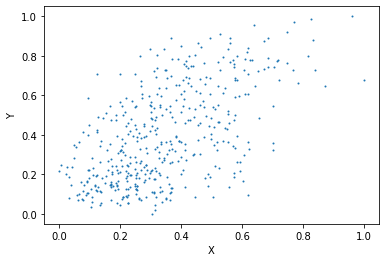

In [117]:
plt.scatter(X[:,0], Y, s=1)
plt.xlabel("X")
plt.ylabel("Y")

#### Learning a BLR model on the entire data

In [0]:
# Change prior appropriately to see variation in predictions
S0 = np.eye(N+1)
M0 = np.array([3, 4, 1, 5, 0.5, 0.5])
clf = BLR(S0, M0)

In [0]:
Y_pred, _ = clf.fit(X, Y, return_self=True)

#### Visualising the fit

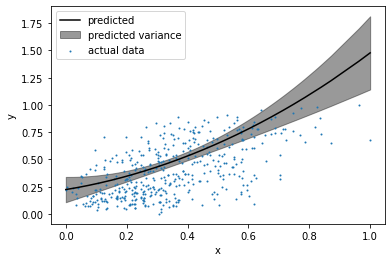

In [120]:
clf.plot(s=1)

#### Creating the initial train set, the test set and the pool

In [0]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
seed = 1

In [0]:
train_pool_X, test_X, train_pool_Y, test_Y = train_test_split(X, Y, test_size = 0.5, random_state=seed)
train_X, pool_X, train_Y, pool_Y = train_test_split(train_pool_X, train_pool_Y, train_size=5, random_state=seed)

Text(0, 0.5, 'Y')

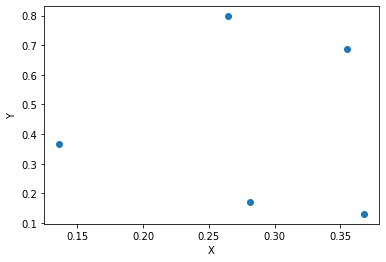

In [123]:
# Initial Train set
plt.scatter(train_X[:,0], train_Y)
plt.xlabel('X')
plt.ylabel('Y')

#### Creating a committee each learnt on different subset of the data

In [0]:
committee_size = 5

In [0]:
train_X_com = {0:{}}
train_Y_com = {0:{}}
models_com = {0:{}}

iteration = 0

for cur_committee in range(committee_size):
    train_X_com[iteration][cur_committee], _, train_Y_com[iteration][cur_committee], _ = train_test_split(train_X, train_Y, train_size=0.5, 
                                                                              random_state=cur_committee)
    models_com[iteration][cur_committee] = BLR(S0, M0)
    models_com[iteration][cur_committee].fit(train_X_com[iteration][cur_committee], train_Y_com[iteration][cur_committee])

#### Plotting the fit of the committee on the entire dataset

Model 0  Y = -0.03 sin(X) + 1.67 X^4 + -0.01 X^3 + -0.00 X^2 + -0.14 X + 1.67
Model 1  Y = 0.82 sin(X) + -0.61 X^4 + 0.28 X^3 + 0.28 X^2 + 0.30 X + -0.61
Model 2  Y = 0.82 sin(X) + -0.61 X^4 + 0.28 X^3 + 0.28 X^2 + 0.30 X + -0.61
Model 3  Y = -1.29 sin(X) + 3.45 X^4 + -0.45 X^3 + -0.44 X^2 + -0.50 X + 3.45
Model 4  Y = 0.39 sin(X) + -0.67 X^4 + 0.14 X^3 + 0.13 X^2 + 0.19 X + -0.67


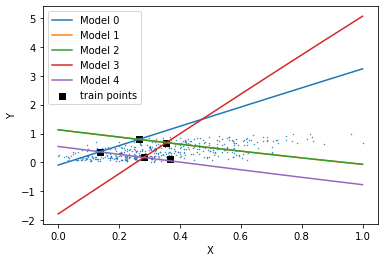

In [126]:
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(X[:,0], Y, s=0.2)
plt.scatter(train_X[:,0], train_Y, marker='s',color='k', label='train points')
for cur_committee in range(committee_size):
    Y_pred_mean, Y_pred_var = models_com[0][cur_committee].predict(X)
    individual_var =Y_pred_var.diagonal()
    #print(individual_var.shape,Y_pred_mean.shape,Y_pred_var.shape)
    print('Model {0}  Y = {1:0.2f} sin(X) + {2:0.2f} X^4 + {3:0.2f} X^3 + {4:0.2f} X^2 + {5:0.2f} X + {6:0.2f}'.format(cur_committee, *models_com[0][cur_committee].MN[::-1]))
    plt.plot(X[:,0], Y_pred_mean, label='Model {0}'.format(cur_committee))
    plt.fill_between(X[:,0], Y_pred_mean-individual_var, Y_pred_mean +individual_var)
    plt.legend()


#### Evaluate the performance on the test set

In [0]:
estimations_com = {0:{}}
for cur_committee in range(committee_size):
    estimations_com[0][cur_committee], _ = models_com[0][cur_committee].predict(test_X)

In [0]:
test_mae_error = {0:(pd.DataFrame(estimations_com[0]).mean(axis=1) - test_Y.squeeze()).abs().mean()}

The MAE on the test set is:

In [129]:
test_mae_error[0]

0.26105036907203755

#### Active learning procedure

In [130]:
num_iterations = 20
points_added_x=np.zeros((num_iterations,N))

points_added_y=[]

print("Iteration, Cost\n")
print("-"*40)

for iteration in range(1, num_iterations):
    # For each committee: making predictions on the pool set based on model learnt in the respective train set 
    estimations_pool = {cur_committee: models_com[iteration-1][cur_committee].predict(pool_X)[0] for cur_committee in range(committee_size)}
    # Finding points from the pool with highest disagreement among the committee - highest standard deviation
    in_var = pd.DataFrame(estimations_pool).std(axis=1).argmax()
    
    to_add_x = pool_X[in_var,:]
    to_add_y = pool_Y[in_var]
    points_added_x[iteration-1,:] = to_add_x
    points_added_y.append(to_add_y)
    
    # For each committee - Adding the point where the committe most disagrees
    for com in range(committee_size):
        if iteration not in train_X_com:
            train_X_com[iteration] = {}
            train_Y_com[iteration] = {}
            models_com[iteration] = {}
        train_X_com[iteration][com] = np.vstack([train_X_com[iteration-1][com], to_add_x])
        train_Y_com[iteration][com] = np.append(train_Y_com[iteration-1][com], to_add_y)
    
    # Deleting the point from the pool
    pool_X = np.delete(pool_X, in_var, axis=0)
    pool_Y = np.delete(pool_Y, in_var)
    
    # Training on the new set for each committee
    for cur_committee in range(committee_size):
        models_com[iteration][cur_committee] = BLR(S0, M0)
        models_com[iteration][cur_committee].fit(train_X_com[iteration][cur_committee], train_Y_com[iteration][cur_committee])
    
    estimations_com[iteration] = {}
    for cur_committee in range(committee_size):
        estimations_com[iteration][cur_committee],_ = models_com[iteration][cur_committee].predict(test_X)
    test_mae_error[iteration]=(pd.DataFrame(estimations_com[iteration]).mean(axis=1) - test_Y.squeeze()).abs().mean()
    print(iteration, (test_mae_error[iteration]))

Iteration, Cost

----------------------------------------
1 0.22849976953215215
2 0.24364802459899107
3 0.21504948086437176
4 0.17903124712744103
5 0.17658505576758265
6 0.18177383789358492
7 0.1738809897308718
8 0.17285006341719789
9 0.17773687618930328
10 0.1766839103433262
11 0.17979173351854094
12 0.17440763885340385
13 0.17674538480736526
14 0.17667312568711907
15 0.17541345997989288
16 0.1763314752129288
17 0.17539168676569208
18 0.17407003598129736
19 0.1726189280608985


Text(0.5, 0, '# Points Queried')

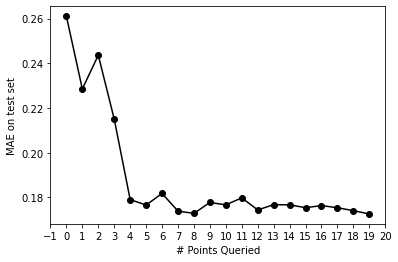

In [131]:
pd.Series(test_mae_error).plot(style='ko-')
plt.xticks(range(-1,num_iterations+1))
plt.ylabel("MAE on test set")
plt.xlabel("# Points Queried")

In [132]:
fig, ax = plt.subplots()
import os
from matplotlib.animation import FuncAnimation
from matplotlib import rc

def update(iteration):
    ax.cla()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.scatter(X[:,0], Y, s=0.2)
    ax.set_title("Iteration: {} \n MAE = {:0.2f}".format(iteration, test_mae_error[iteration]))
    for cur_committee in range(committee_size):
      Y_pred_mean, Y_pred_var = models_com[iteration][cur_committee].predict(X)
      individual_var =Y_pred_var.diagonal()
      #print('Model {0}  Y = {1:0.2f} sin(X) + {2:0.2f} X^4 + {3:0.2f} X^3 + {4:0.2f} X^2 + {5:0.2f} X + {6:0.2f}'.format(cur_committee, *models_com[0][cur_committee].MN[::-1]))
      ax.plot(X[:,0], Y_pred_mean, label='Model {0}'.format(cur_committee))
      ax.fill_between(X[:,0], Y_pred_mean-individual_var, Y_pred_mean +individual_var)
    if iteration != 0:
      ax.scatter(points_added_x[:iteration-1,0], points_added_y[:iteration-1],s=10, color='k', marker='s', label='train points')
    ax.scatter(points_added_x[iteration,0], points_added_y[iteration],s=50, color='red')
    ax.legend()
    
    fig.tight_layout()
print('Initial curves')
for cur_committee in range(committee_size):
  print('Model {0}  Y = {1:0.2f} sin(X) + {2:0.2f} X^4 + {3:0.2f} X^3 + {4:0.2f} X^2 + {5:0.2f} X + {6:0.2f}'.format(cur_committee, *models_com[0][cur_committee].MN[::-1]))

print('\nFinal curves')
for cur_committee in range(committee_size):
  print('Model {0}  Y = {1:0.2f} sin(X) + {2:0.2f} X^4 + {3:0.2f} X^3 + {4:0.2f} X^2 + {5:0.2f} X + {6:0.2f}'.format(cur_committee, *models_com[num_iterations-1][cur_committee].MN[::-1]))


anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations-1, 1), interval=250)
plt.close()

rc('animation', html='jshtml')
anim

Initial curves
Model 0  Y = -0.03 sin(X) + 1.67 X^4 + -0.01 X^3 + -0.00 X^2 + -0.14 X + 1.67
Model 1  Y = 0.82 sin(X) + -0.61 X^4 + 0.28 X^3 + 0.28 X^2 + 0.30 X + -0.61
Model 2  Y = 0.82 sin(X) + -0.61 X^4 + 0.28 X^3 + 0.28 X^2 + 0.30 X + -0.61
Model 3  Y = -1.29 sin(X) + 3.45 X^4 + -0.45 X^3 + -0.44 X^2 + -0.50 X + 3.45
Model 4  Y = 0.39 sin(X) + -0.67 X^4 + 0.14 X^3 + 0.13 X^2 + 0.19 X + -0.67

Final curves
Model 0  Y = -2.24 sin(X) + -0.89 X^4 + 4.05 X^3 + 0.05 X^2 + 2.96 X + 1.61
Model 1  Y = -2.23 sin(X) + -0.89 X^4 + 4.06 X^3 + 0.05 X^2 + 2.95 X + 1.61
Model 2  Y = -2.23 sin(X) + -0.89 X^4 + 4.06 X^3 + 0.05 X^2 + 2.95 X + 1.61
Model 3  Y = -2.27 sin(X) + -0.88 X^4 + 4.04 X^3 + 0.04 X^2 + 2.96 X + 1.62
Model 4  Y = -2.28 sin(X) + -0.89 X^4 + 4.04 X^3 + 0.03 X^2 + 2.97 X + 1.61


Shaded part in the above plot shows the variance or the uncertainity about the predictions. Now let's make use of this into our next active learning technique

## Uncertainity Sampling

In this method, in each iteration, we add a sample from pool set to train set, for which we are most uncertain. In other words, for which our model has the highest predicted varience.

#### Training initial learner on few samples from train set

In [0]:
train_X_iter = {0:None}
train_Y_iter = {0:None}
models = {0:None}

iteration = 0

train_pool_X, test_X, train_pool_Y, test_Y = train_test_split(X, Y, test_size = 0.5, random_state=seed)
train_X, pool_X, train_Y, pool_Y = train_test_split(train_pool_X, train_pool_Y, train_size=5, random_state=seed)


train_X_iter[iteration], _, train_Y_iter[iteration], _ = train_test_split(train_X, train_Y, train_size=2, 
                                                                          random_state=seed)

models[iteration] = BLR(S0, M0)
models[iteration].fit(train_X_iter[iteration], train_Y_iter[iteration])

#### Evaluate the performance on the test set

In [0]:
estimations = {0:None}

estimations[0], _ = models[0].predict(test_X)

In [0]:
test_mae_error = {0:pd.Series(estimations[0] - test_Y.squeeze()).abs().mean()}

The MAE on the test set is:

In [136]:
test_mae_error[0]

0.4099283124619056

#### Active learning procedure

In [137]:
num_iterations = 20
points_added_x= np.zeros((num_iterations, N))

points_added_y=[]

print("Iteration, Cost\n")
print("-"*40)

for iteration in range(1, num_iterations):
    # For each committee: making predictions on the pool set based on model learnt in the respective train set 
    estimations_pool = models[iteration-1].predict(pool_X)
    # Finding points from the pool with highest standard deviation
    in_var = models[iteration-1].pred_var.diagonal().argmax()
    
    to_add_x = pool_X[in_var,:]
    to_add_y = pool_Y[in_var]
    points_added_x[iteration-1,:] = to_add_x
    points_added_y.append(to_add_y)
    
    # For each committee - Adding the point where the committe most disagrees
    if iteration not in train_X:
      train_X_iter[iteration] = {}
      train_Y_iter[iteration] = {}
      models[iteration] = {}
    train_X_iter[iteration] = np.vstack([train_X_iter[iteration-1], to_add_x])
    train_Y_iter[iteration] = np.append(train_Y_iter[iteration-1], to_add_y)
    
    # Deleting the point from the pool
    pool_X = np.delete(pool_X, in_var, axis=0)
    pool_Y = np.delete(pool_Y, in_var)
    
    # Training on the new set
    models[iteration] = BLR(S0, M0)
    models[iteration].fit(train_X_iter[iteration], train_Y_iter[iteration])
    
    estimations[iteration], _ = models[iteration].predict(test_X)
    test_mae_error[iteration]= pd.Series(estimations[iteration] - test_Y.squeeze()).abs().mean()
    print(iteration, (test_mae_error[iteration]))

Iteration, Cost

----------------------------------------
1 0.41216386818265915
2 0.3427156354500735
3 0.3645268701607001
4 0.2250740585901274
5 0.2054233780866724
6 0.1947542141680048
7 0.1856913811769029
8 0.18199936579521386
9 0.18493321097145396
10 0.18225230536024165
11 0.1800965792357033
12 0.17966704606340975
13 0.17817976493632826
14 0.17944147318674905
15 0.17864535506509077
16 0.17581733373570158
17 0.17321371337681654
18 0.1751158155545536
19 0.17331138803637708


Text(0.5, 0, '# Points Queried')

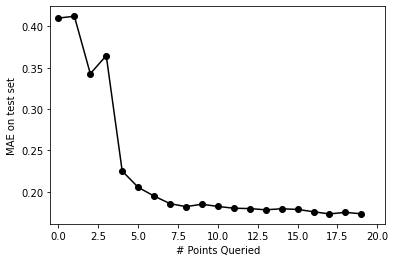

In [138]:
pd.Series(test_mae_error).plot(style='ko-')
plt.xlim((-0.5, num_iterations+0.5))
plt.ylabel("MAE on test set")
plt.xlabel("# Points Queried")

In [139]:
fig, ax = plt.subplots()
import os
from matplotlib.animation import FuncAnimation
from matplotlib import rc

def update(iteration):
    ax.cla()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.scatter(X[:,0], Y, s=0.2)
    ax.set_title("Iteration: {} \n MAE = {:0.2f}".format(iteration, test_mae_error[iteration]))
    Y_pred_mean, Y_pred_var = models[iteration].predict(X)
    individual_var =Y_pred_var.diagonal()
    #print(individual_var.shape,Y_pred_mean.shape,Y_pred_var.shape)
    ax.plot(X[:,0], Y_pred_mean, label='predicted curve', color='k')
    ax.fill_between(X[:,0], Y_pred_mean-individual_var, Y_pred_mean +individual_var, label = 'predicted variance')
    
    ax.scatter(train_X_iter[iteration][:,0], train_Y_iter[iteration],s=10, color='k', marker='s', label='train points')
    ax.scatter(points_added_x[iteration,0], points_added_y[iteration],s=50, color='red')
    ax.legend()
    
    fig.tight_layout()

print('Initial curve')
print('Y = {0:0.2f} sin(X) + {1:0.2f} X^4 + {2:0.2f} X^3 + {3:0.2f} X^2 + {4:0.2f} X + {5:0.2f}'.format(*models_com[0][cur_committee].MN[::-1]))

print('\nFinal curve')
print('Y = {0:0.2f} sin(X) + {1:0.2f} X^4 + {2:0.2f} X^3 + {3:0.2f} X^2 + {4:0.2f} X + {5:0.2f}'.format(*models_com[num_iterations-1][cur_committee].MN[::-1]))

anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations-1, 1), interval=250)
plt.close()

rc('animation', html='jshtml')
anim

Initial curve
Y = 0.39 sin(X) + -0.67 X^4 + 0.14 X^3 + 0.13 X^2 + 0.19 X + -0.67

Final curve
Y = -2.28 sin(X) + -0.89 X^4 + 4.04 X^3 + 0.03 X^2 + 2.97 X + 1.61
